In [1]:
from typing import List, Optional, Callable, Iterable
from itertools import islice
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import torch
import torch.nn as nn
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import StudentTOutput
from gluonts.model.forecast_generator import DistributionForecastGenerator

import lightning.pytorch as pl
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddObservedValuesIndicator,
    InstanceSplitter,
    ExpectedNumInstanceSampler,
    TestSplitSampler,
)
from gluonts.evaluation import make_evaluation_predictions, Evaluator
# from gluonts.torch.model.tft.module import TemporalFusionTransformerModel
from gluonts.torch.model.tft import TemporalFusionTransformerEstimator  
# from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.dataset.common import (
    FileDataset, ListDataset, TrainDatasets,
    CategoricalFeatureInfo, BasicFeatureInfo,
)
from gluonts.dataset.loader import TrainDataLoader, InferenceDataLoader
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from datasets import Dataset, Features, Value, Sequence

/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
id_sensor = pd.read_csv('/home/seyed/PycharmProjects/step/STEP/datasets/METR-LA/graph_sensor_locations.csv', index_col=0)
adj_path = "/home/seyed/PycharmProjects/step/STEP/datasets/raw_data/METR-LA/adj_METR-LA_nn.json"
rev_map = json.loads(id_sensor["sensor_id"].to_json())
main_map = {str(v):k for k,v in rev_map.items()}
nn_data = None
with open(adj_path, "r") as f:
    nn_data = json.load(f)
q = []
for i in nn_data:
    if i != "26":
        if len(nn_data[i]["1_hop"]["nodes"]) == 1:
            print(i, nn_data[i], rev_map[str(i)])
        q.append(len(nn_data[i]["1_hop"]["nodes"]))
DROP_IND = "26"
DROP_SENSOR = rev_map[DROP_IND]
df = pd.read_hdf("/home/seyed/Downloads/metr-la(1).h5")
df_new = df.copy()
aggregated = []
# ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")
KNN = 3
for column in df_new.columns:
    if column != str(DROP_SENSOR):
        first_nn = nn_data[main_map[column]]["1_hop"]["nodes"]
        cols = [str(rev_map[str(i)]) for i in first_nn[:KNN]]
        aggregated.append(df_new[cols].values.T)
df.drop(columns=[str(DROP_SENSOR)], inplace=True)
df_new.drop(columns=[str(DROP_SENSOR)], inplace=True)
df.index = pd.to_datetime(df.index)
df.index.freq='5min'
history_seq_len = 2016
future_seq_len = 12
len_of_df = len(df)
num_samples = len_of_df - (history_seq_len + future_seq_len) + 1
    # keep same number of validation and test samples with Graph WaveNet (input 12, output 12)
test_num_short = 200
valid_num_short = 200
# train_num_short = num_samples - valid_num_short - test_num_short
train_num_short = 31845
train_data = df[:train_num_short]
feat_time = [ddd[:, :train_num_short] for ddd in aggregated]
test_data = df
feat_time[0].shape
def to_deepar_format(dataframe, time_feature):
    freq = pd.infer_freq(dataframe.index) 
    start_index = dataframe.index.min()
    data = [{
                FieldName.START:  start_index,
                FieldName.TARGET:  dataframe[c].values,
                # FieldName.FEAT_DYNAMIC_REAL: time_feature[i],
                FieldName.ITEM_ID: i,
                "data_id": i
            } 
            for i, c in enumerate(dataframe.columns)]
    # print(data[0]["feat_dynamic_real"].shape)
    return ListDataset(data, freq=freq)
train_data_lds = to_deepar_format(train_data, feat_time)
test_data_lds = to_deepar_format(test_data, aggregated)

In [3]:
from gluonts.dataset.common import MetaData

In [4]:
meta_data = MetaData(freq=pd.infer_freq(df.index), prediction_length=future_seq_len)

In [5]:
dataset = TrainDatasets(train=train_data_lds, test=test_data_lds, metadata=meta_data)

In [6]:


def train_script(model, checkpoint="/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_22/checkpoints/epoch=98-step=99000.ckpt"):
    predictor = model.train(dataset.train, ckpt_path=checkpoint)
    forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
    )
    evaluator = Evaluator(
        seasonality=1
    )
    agg_m, item_m = evaluator(
        ts_iterator=ts_it,
        fcst_iterator=forecast_it,
        num_series=len(dataset.test),
    )
    print(json.dumps(agg_m, indent=4))
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )
    return forecast_it, ts_it, predictor
    


In [7]:
def plot(forecast_it, ts_it):
    plt.figure(figsize=(20, 15))
    date_formater = mdates.DateFormatter('%b, %d, %Y, %H:%M')
    plt.rcParams.update({'font.size': 15})

    for idx, (forecast, ts) in islice(enumerate(zip(forecast_it, ts_it)), 9):
        print(forecast)
        ax = plt.subplot(3, 3, idx+1)

        plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
        forecast.plot(color='r')
        plt.xticks(rotation=60)
        ax.xaxis.set_major_formatter(date_formater)
        ax.set_title(forecast.item_id)

    plt.gcf().tight_layout()
    plt.legend()
    plt.show()

In [8]:
import os

file_path = "./checkpoints/lag-llama.ckpt"
if os.path.exists(file_path):
    print("File exists")
else:
    print("File does not exist")


File exists


In [9]:
from lag_llama.gluon.estimator import LagLlamaEstimator

ckpt = torch.load("checkpoints/lag-llama.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
# input_size = estimator_args["input_size"]
input_size = estimator_args["input_size"] + 2
estimator = LagLlamaEstimator(
    ckpt_path="checkpoints/lag-llama.ckpt",
    prediction_length=12,
    context_length=168,
    # estimator args
    input_size=input_size,
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    num_batches_per_epoch=1000,
)

In [10]:
# Lora training
estimator.train(dataset.train, ckpt_path=None)

RuntimeError: Error(s) in loading state_dict for LagLlamaLightningModule:
	Missing key(s) in state_dict: "model.base_model.model.param_proj.proj.0.weight", "model.base_model.model.param_proj.proj.0.bias", "model.base_model.model.param_proj.proj.1.weight", "model.base_model.model.param_proj.proj.1.bias", "model.base_model.model.param_proj.proj.2.weight", "model.base_model.model.param_proj.proj.2.bias", "model.base_model.model.transformer.wte.weight", "model.base_model.model.transformer.wte.bias", "model.base_model.model.transformer.h.0.rms_1.scale", "model.base_model.model.transformer.h.0.attn.q_proj.base_layer.weight", "model.base_model.model.transformer.h.0.attn.q_proj.lora_A.default.weight", "model.base_model.model.transformer.h.0.attn.q_proj.lora_B.default.weight", "model.base_model.model.transformer.h.0.attn.kv_proj.base_layer.weight", "model.base_model.model.transformer.h.0.attn.kv_proj.lora_A.default.weight", "model.base_model.model.transformer.h.0.attn.kv_proj.lora_B.default.weight", "model.base_model.model.transformer.h.0.attn.c_proj.weight", "model.base_model.model.transformer.h.0.rms_2.scale", "model.base_model.model.transformer.h.0.mlp.c_fc1.weight", "model.base_model.model.transformer.h.0.mlp.c_fc2.weight", "model.base_model.model.transformer.h.0.mlp.c_proj.weight", "model.base_model.model.transformer.h.1.rms_1.scale", "model.base_model.model.transformer.h.1.attn.q_proj.base_layer.weight", "model.base_model.model.transformer.h.1.attn.q_proj.lora_A.default.weight", "model.base_model.model.transformer.h.1.attn.q_proj.lora_B.default.weight", "model.base_model.model.transformer.h.1.attn.kv_proj.base_layer.weight", "model.base_model.model.transformer.h.1.attn.kv_proj.lora_A.default.weight", "model.base_model.model.transformer.h.1.attn.kv_proj.lora_B.default.weight", "model.base_model.model.transformer.h.1.attn.c_proj.weight", "model.base_model.model.transformer.h.1.rms_2.scale", "model.base_model.model.transformer.h.1.mlp.c_fc1.weight", "model.base_model.model.transformer.h.1.mlp.c_fc2.weight", "model.base_model.model.transformer.h.1.mlp.c_proj.weight", "model.base_model.model.transformer.h.2.rms_1.scale", "model.base_model.model.transformer.h.2.attn.q_proj.base_layer.weight", "model.base_model.model.transformer.h.2.attn.q_proj.lora_A.default.weight", "model.base_model.model.transformer.h.2.attn.q_proj.lora_B.default.weight", "model.base_model.model.transformer.h.2.attn.kv_proj.base_layer.weight", "model.base_model.model.transformer.h.2.attn.kv_proj.lora_A.default.weight", "model.base_model.model.transformer.h.2.attn.kv_proj.lora_B.default.weight", "model.base_model.model.transformer.h.2.attn.c_proj.weight", "model.base_model.model.transformer.h.2.rms_2.scale", "model.base_model.model.transformer.h.2.mlp.c_fc1.weight", "model.base_model.model.transformer.h.2.mlp.c_fc2.weight", "model.base_model.model.transformer.h.2.mlp.c_proj.weight", "model.base_model.model.transformer.h.3.rms_1.scale", "model.base_model.model.transformer.h.3.attn.q_proj.base_layer.weight", "model.base_model.model.transformer.h.3.attn.q_proj.lora_A.default.weight", "model.base_model.model.transformer.h.3.attn.q_proj.lora_B.default.weight", "model.base_model.model.transformer.h.3.attn.kv_proj.base_layer.weight", "model.base_model.model.transformer.h.3.attn.kv_proj.lora_A.default.weight", "model.base_model.model.transformer.h.3.attn.kv_proj.lora_B.default.weight", "model.base_model.model.transformer.h.3.attn.c_proj.weight", "model.base_model.model.transformer.h.3.rms_2.scale", "model.base_model.model.transformer.h.3.mlp.c_fc1.weight", "model.base_model.model.transformer.h.3.mlp.c_fc2.weight", "model.base_model.model.transformer.h.3.mlp.c_proj.weight", "model.base_model.model.transformer.h.4.rms_1.scale", "model.base_model.model.transformer.h.4.attn.q_proj.base_layer.weight", "model.base_model.model.transformer.h.4.attn.q_proj.lora_A.default.weight", "model.base_model.model.transformer.h.4.attn.q_proj.lora_B.default.weight", "model.base_model.model.transformer.h.4.attn.kv_proj.base_layer.weight", "model.base_model.model.transformer.h.4.attn.kv_proj.lora_A.default.weight", "model.base_model.model.transformer.h.4.attn.kv_proj.lora_B.default.weight", "model.base_model.model.transformer.h.4.attn.c_proj.weight", "model.base_model.model.transformer.h.4.rms_2.scale", "model.base_model.model.transformer.h.4.mlp.c_fc1.weight", "model.base_model.model.transformer.h.4.mlp.c_fc2.weight", "model.base_model.model.transformer.h.4.mlp.c_proj.weight", "model.base_model.model.transformer.h.5.rms_1.scale", "model.base_model.model.transformer.h.5.attn.q_proj.base_layer.weight", "model.base_model.model.transformer.h.5.attn.q_proj.lora_A.default.weight", "model.base_model.model.transformer.h.5.attn.q_proj.lora_B.default.weight", "model.base_model.model.transformer.h.5.attn.kv_proj.base_layer.weight", "model.base_model.model.transformer.h.5.attn.kv_proj.lora_A.default.weight", "model.base_model.model.transformer.h.5.attn.kv_proj.lora_B.default.weight", "model.base_model.model.transformer.h.5.attn.c_proj.weight", "model.base_model.model.transformer.h.5.rms_2.scale", "model.base_model.model.transformer.h.5.mlp.c_fc1.weight", "model.base_model.model.transformer.h.5.mlp.c_fc2.weight", "model.base_model.model.transformer.h.5.mlp.c_proj.weight", "model.base_model.model.transformer.h.6.rms_1.scale", "model.base_model.model.transformer.h.6.attn.q_proj.base_layer.weight", "model.base_model.model.transformer.h.6.attn.q_proj.lora_A.default.weight", "model.base_model.model.transformer.h.6.attn.q_proj.lora_B.default.weight", "model.base_model.model.transformer.h.6.attn.kv_proj.base_layer.weight", "model.base_model.model.transformer.h.6.attn.kv_proj.lora_A.default.weight", "model.base_model.model.transformer.h.6.attn.kv_proj.lora_B.default.weight", "model.base_model.model.transformer.h.6.attn.c_proj.weight", "model.base_model.model.transformer.h.6.rms_2.scale", "model.base_model.model.transformer.h.6.mlp.c_fc1.weight", "model.base_model.model.transformer.h.6.mlp.c_fc2.weight", "model.base_model.model.transformer.h.6.mlp.c_proj.weight", "model.base_model.model.transformer.h.7.rms_1.scale", "model.base_model.model.transformer.h.7.attn.q_proj.base_layer.weight", "model.base_model.model.transformer.h.7.attn.q_proj.lora_A.default.weight", "model.base_model.model.transformer.h.7.attn.q_proj.lora_B.default.weight", "model.base_model.model.transformer.h.7.attn.kv_proj.base_layer.weight", "model.base_model.model.transformer.h.7.attn.kv_proj.lora_A.default.weight", "model.base_model.model.transformer.h.7.attn.kv_proj.lora_B.default.weight", "model.base_model.model.transformer.h.7.attn.c_proj.weight", "model.base_model.model.transformer.h.7.rms_2.scale", "model.base_model.model.transformer.h.7.mlp.c_fc1.weight", "model.base_model.model.transformer.h.7.mlp.c_fc2.weight", "model.base_model.model.transformer.h.7.mlp.c_proj.weight", "model.base_model.model.transformer.ln_f.scale". 
	Unexpected key(s) in state_dict: "model.param_proj.proj.0.weight", "model.param_proj.proj.0.bias", "model.param_proj.proj.1.weight", "model.param_proj.proj.1.bias", "model.param_proj.proj.2.weight", "model.param_proj.proj.2.bias", "model.transformer.wte.weight", "model.transformer.wte.bias", "model.transformer.h.0.rms_1.scale", "model.transformer.h.0.attn.q_proj.weight", "model.transformer.h.0.attn.kv_proj.weight", "model.transformer.h.0.attn.c_proj.weight", "model.transformer.h.0.rms_2.scale", "model.transformer.h.0.mlp.c_fc1.weight", "model.transformer.h.0.mlp.c_fc2.weight", "model.transformer.h.0.mlp.c_proj.weight", "model.transformer.h.1.rms_1.scale", "model.transformer.h.1.attn.q_proj.weight", "model.transformer.h.1.attn.kv_proj.weight", "model.transformer.h.1.attn.c_proj.weight", "model.transformer.h.1.rms_2.scale", "model.transformer.h.1.mlp.c_fc1.weight", "model.transformer.h.1.mlp.c_fc2.weight", "model.transformer.h.1.mlp.c_proj.weight", "model.transformer.h.2.rms_1.scale", "model.transformer.h.2.attn.q_proj.weight", "model.transformer.h.2.attn.kv_proj.weight", "model.transformer.h.2.attn.c_proj.weight", "model.transformer.h.2.rms_2.scale", "model.transformer.h.2.mlp.c_fc1.weight", "model.transformer.h.2.mlp.c_fc2.weight", "model.transformer.h.2.mlp.c_proj.weight", "model.transformer.h.3.rms_1.scale", "model.transformer.h.3.attn.q_proj.weight", "model.transformer.h.3.attn.kv_proj.weight", "model.transformer.h.3.attn.c_proj.weight", "model.transformer.h.3.rms_2.scale", "model.transformer.h.3.mlp.c_fc1.weight", "model.transformer.h.3.mlp.c_fc2.weight", "model.transformer.h.3.mlp.c_proj.weight", "model.transformer.h.4.rms_1.scale", "model.transformer.h.4.attn.q_proj.weight", "model.transformer.h.4.attn.kv_proj.weight", "model.transformer.h.4.attn.c_proj.weight", "model.transformer.h.4.rms_2.scale", "model.transformer.h.4.mlp.c_fc1.weight", "model.transformer.h.4.mlp.c_fc2.weight", "model.transformer.h.4.mlp.c_proj.weight", "model.transformer.h.5.rms_1.scale", "model.transformer.h.5.attn.q_proj.weight", "model.transformer.h.5.attn.kv_proj.weight", "model.transformer.h.5.attn.c_proj.weight", "model.transformer.h.5.rms_2.scale", "model.transformer.h.5.mlp.c_fc1.weight", "model.transformer.h.5.mlp.c_fc2.weight", "model.transformer.h.5.mlp.c_proj.weight", "model.transformer.h.6.rms_1.scale", "model.transformer.h.6.attn.q_proj.weight", "model.transformer.h.6.attn.kv_proj.weight", "model.transformer.h.6.attn.c_proj.weight", "model.transformer.h.6.rms_2.scale", "model.transformer.h.6.mlp.c_fc1.weight", "model.transformer.h.6.mlp.c_fc2.weight", "model.transformer.h.6.mlp.c_proj.weight", "model.transformer.h.7.rms_1.scale", "model.transformer.h.7.attn.q_proj.weight", "model.transformer.h.7.attn.kv_proj.weight", "model.transformer.h.7.attn.c_proj.weight", "model.transformer.h.7.rms_2.scale", "model.transformer.h.7.mlp.c_fc1.weight", "model.transformer.h.7.mlp.c_fc2.weight", "model.transformer.h.7.mlp.c_proj.weight", "model.transformer.ln_f.scale". 

In [19]:
# train_script(estimator, checkpoint=None)
estimator.train(dataset.train, ckpt_path=None)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.798     Total estimated model params size (MB)


None
Epoch 0: |          | 1000/? [02:38<00:00,  6.30it/s, v_num=69]

Epoch 0, global step 1000: 'train_loss' reached 2.89083 (best 2.89083), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=0-step=1000.ckpt' as top 1


Epoch 1: |          | 1000/? [02:40<00:00,  6.25it/s, v_num=69]

Epoch 1, global step 2000: 'train_loss' reached 2.60342 (best 2.60342), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=1-step=2000.ckpt' as top 1


Epoch 2: |          | 1000/? [02:40<00:00,  6.24it/s, v_num=69]

Epoch 2, global step 3000: 'train_loss' reached 2.56242 (best 2.56242), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=2-step=3000.ckpt' as top 1


Epoch 3: |          | 1000/? [02:40<00:00,  6.24it/s, v_num=69]

Epoch 3, global step 4000: 'train_loss' reached 2.51561 (best 2.51561), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=3-step=4000.ckpt' as top 1


Epoch 4: |          | 1000/? [02:37<00:00,  6.34it/s, v_num=69]

Epoch 4, global step 5000: 'train_loss' reached 2.50770 (best 2.50770), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=4-step=5000.ckpt' as top 1


Epoch 5: |          | 1000/? [02:39<00:00,  6.28it/s, v_num=69]

Epoch 5, global step 6000: 'train_loss' reached 2.46206 (best 2.46206), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=5-step=6000.ckpt' as top 1


Epoch 6: |          | 1000/? [02:34<00:00,  6.46it/s, v_num=69]

Epoch 6, global step 7000: 'train_loss' reached 2.44320 (best 2.44320), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=6-step=7000.ckpt' as top 1


Epoch 7: |          | 1000/? [02:35<00:00,  6.45it/s, v_num=69]

Epoch 7, global step 8000: 'train_loss' reached 2.42571 (best 2.42571), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=7-step=8000.ckpt' as top 1


Epoch 8: |          | 1000/? [02:32<00:00,  6.54it/s, v_num=69]

Epoch 8, global step 9000: 'train_loss' was not in top 1


Epoch 9: |          | 1000/? [02:32<00:00,  6.56it/s, v_num=69]

Epoch 9, global step 10000: 'train_loss' reached 2.41688 (best 2.41688), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=9-step=10000.ckpt' as top 1


Epoch 10: |          | 1000/? [02:31<00:00,  6.61it/s, v_num=69]

Epoch 10, global step 11000: 'train_loss' reached 2.39343 (best 2.39343), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=10-step=11000.ckpt' as top 1


Epoch 11: |          | 1000/? [02:32<00:00,  6.56it/s, v_num=69]

Epoch 11, global step 12000: 'train_loss' reached 2.39021 (best 2.39021), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=11-step=12000.ckpt' as top 1


Epoch 12: |          | 1000/? [02:32<00:00,  6.56it/s, v_num=69]

Epoch 12, global step 13000: 'train_loss' reached 2.38186 (best 2.38186), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=12-step=13000.ckpt' as top 1


Epoch 13: |          | 1000/? [02:31<00:00,  6.59it/s, v_num=69]

Epoch 13, global step 14000: 'train_loss' reached 2.37634 (best 2.37634), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=13-step=14000.ckpt' as top 1


Epoch 14: |          | 1000/? [02:32<00:00,  6.54it/s, v_num=69]

Epoch 14, global step 15000: 'train_loss' was not in top 1


Epoch 15: |          | 1000/? [02:31<00:00,  6.58it/s, v_num=69]

Epoch 15, global step 16000: 'train_loss' reached 2.37360 (best 2.37360), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=15-step=16000.ckpt' as top 1


Epoch 16: |          | 1000/? [02:34<00:00,  6.49it/s, v_num=69]

Epoch 16, global step 17000: 'train_loss' reached 2.34979 (best 2.34979), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=16-step=17000.ckpt' as top 1


Epoch 17: |          | 1000/? [02:33<00:00,  6.50it/s, v_num=69]

Epoch 17, global step 18000: 'train_loss' was not in top 1


Epoch 18: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 18, global step 19000: 'train_loss' reached 2.32897 (best 2.32897), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=18-step=19000.ckpt' as top 1


Epoch 19: |          | 1000/? [02:34<00:00,  6.49it/s, v_num=69]

Epoch 19, global step 20000: 'train_loss' was not in top 1


Epoch 20: |          | 1000/? [02:33<00:00,  6.52it/s, v_num=69]

Epoch 20, global step 21000: 'train_loss' was not in top 1


Epoch 21: |          | 1000/? [02:33<00:00,  6.51it/s, v_num=69]

Epoch 21, global step 22000: 'train_loss' was not in top 1


Epoch 22: |          | 1000/? [02:31<00:00,  6.58it/s, v_num=69]

Epoch 22, global step 23000: 'train_loss' was not in top 1


Epoch 23: |          | 1000/? [02:32<00:00,  6.54it/s, v_num=69]

Epoch 23, global step 24000: 'train_loss' reached 2.30005 (best 2.30005), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=23-step=24000.ckpt' as top 1


Epoch 24: |          | 1000/? [02:32<00:00,  6.58it/s, v_num=69]

Epoch 24, global step 25000: 'train_loss' was not in top 1


Epoch 25: |          | 1000/? [02:33<00:00,  6.52it/s, v_num=69]

Epoch 25, global step 26000: 'train_loss' reached 2.28864 (best 2.28864), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=25-step=26000.ckpt' as top 1


Epoch 26: |          | 1000/? [02:32<00:00,  6.57it/s, v_num=69]

Epoch 26, global step 27000: 'train_loss' was not in top 1


Epoch 27: |          | 1000/? [02:33<00:00,  6.50it/s, v_num=69]

Epoch 27, global step 28000: 'train_loss' was not in top 1


Epoch 28: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 28, global step 29000: 'train_loss' reached 2.27965 (best 2.27965), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=28-step=29000.ckpt' as top 1


Epoch 29: |          | 1000/? [02:33<00:00,  6.51it/s, v_num=69]

Epoch 29, global step 30000: 'train_loss' was not in top 1


Epoch 30: |          | 1000/? [02:34<00:00,  6.49it/s, v_num=69]

Epoch 30, global step 31000: 'train_loss' was not in top 1


Epoch 31: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 31, global step 32000: 'train_loss' was not in top 1


Epoch 32: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 32, global step 33000: 'train_loss' reached 2.27362 (best 2.27362), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=32-step=33000.ckpt' as top 1


Epoch 33: |          | 1000/? [02:31<00:00,  6.61it/s, v_num=69]

Epoch 33, global step 34000: 'train_loss' was not in top 1


Epoch 34: |          | 1000/? [02:33<00:00,  6.52it/s, v_num=69]

Epoch 34, global step 35000: 'train_loss' reached 2.24821 (best 2.24821), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=34-step=35000.ckpt' as top 1


Epoch 35: |          | 1000/? [02:33<00:00,  6.53it/s, v_num=69]

Epoch 35, global step 36000: 'train_loss' was not in top 1


Epoch 36: |          | 1000/? [02:32<00:00,  6.56it/s, v_num=69]

Epoch 36, global step 37000: 'train_loss' was not in top 1


Epoch 37: |          | 1000/? [02:32<00:00,  6.56it/s, v_num=69]

Epoch 37, global step 38000: 'train_loss' reached 2.24161 (best 2.24161), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=37-step=38000.ckpt' as top 1


Epoch 38: |          | 1000/? [02:32<00:00,  6.56it/s, v_num=69]

Epoch 38, global step 39000: 'train_loss' was not in top 1


Epoch 39: |          | 1000/? [02:33<00:00,  6.53it/s, v_num=69]

Epoch 39, global step 40000: 'train_loss' was not in top 1


Epoch 40: |          | 1000/? [02:33<00:00,  6.50it/s, v_num=69]

Epoch 40, global step 41000: 'train_loss' reached 2.23414 (best 2.23414), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=40-step=41000.ckpt' as top 1


Epoch 41: |          | 1000/? [02:33<00:00,  6.53it/s, v_num=69]

Epoch 41, global step 42000: 'train_loss' was not in top 1


Epoch 42: |          | 1000/? [02:34<00:00,  6.48it/s, v_num=69]

Epoch 42, global step 43000: 'train_loss' reached 2.22914 (best 2.22914), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=42-step=43000.ckpt' as top 1


Epoch 43: |          | 1000/? [02:32<00:00,  6.56it/s, v_num=69]

Epoch 43, global step 44000: 'train_loss' reached 2.22533 (best 2.22533), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=43-step=44000.ckpt' as top 1


Epoch 44: |          | 1000/? [02:33<00:00,  6.53it/s, v_num=69]

Epoch 44, global step 45000: 'train_loss' reached 2.21541 (best 2.21541), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=44-step=45000.ckpt' as top 1


Epoch 45: |          | 1000/? [02:34<00:00,  6.48it/s, v_num=69]

Epoch 45, global step 46000: 'train_loss' was not in top 1


Epoch 46: |          | 1000/? [02:31<00:00,  6.59it/s, v_num=69]

Epoch 46, global step 47000: 'train_loss' was not in top 1


Epoch 47: |          | 1000/? [02:33<00:00,  6.51it/s, v_num=69]

Epoch 47, global step 48000: 'train_loss' was not in top 1


Epoch 48: |          | 1000/? [02:34<00:00,  6.46it/s, v_num=69]

Epoch 48, global step 49000: 'train_loss' reached 2.20905 (best 2.20905), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=48-step=49000.ckpt' as top 1


Epoch 49: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 49, global step 50000: 'train_loss' was not in top 1


Epoch 50: |          | 1000/? [02:32<00:00,  6.57it/s, v_num=69]

Epoch 50, global step 51000: 'train_loss' reached 2.20083 (best 2.20083), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=50-step=51000.ckpt' as top 1


Epoch 51: |          | 1000/? [02:33<00:00,  6.52it/s, v_num=69]

Epoch 51, global step 52000: 'train_loss' reached 2.20067 (best 2.20067), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=51-step=52000.ckpt' as top 1


Epoch 52: |          | 1000/? [02:33<00:00,  6.53it/s, v_num=69]

Epoch 52, global step 53000: 'train_loss' was not in top 1


Epoch 53: |          | 1000/? [02:33<00:00,  6.50it/s, v_num=69]

Epoch 53, global step 54000: 'train_loss' was not in top 1


Epoch 54: |          | 1000/? [02:33<00:00,  6.51it/s, v_num=69]

Epoch 54, global step 55000: 'train_loss' reached 2.19885 (best 2.19885), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=54-step=55000.ckpt' as top 1


Epoch 55: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 55, global step 56000: 'train_loss' was not in top 1


Epoch 56: |          | 1000/? [02:34<00:00,  6.48it/s, v_num=69]

Epoch 56, global step 57000: 'train_loss' reached 2.19626 (best 2.19626), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=56-step=57000.ckpt' as top 1


Epoch 57: |          | 1000/? [02:31<00:00,  6.61it/s, v_num=69]

Epoch 57, global step 58000: 'train_loss' reached 2.18550 (best 2.18550), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=57-step=58000.ckpt' as top 1


Epoch 58: |          | 1000/? [02:33<00:00,  6.52it/s, v_num=69]

Epoch 58, global step 59000: 'train_loss' was not in top 1


Epoch 59: |          | 1000/? [02:32<00:00,  6.56it/s, v_num=69]

Epoch 59, global step 60000: 'train_loss' reached 2.17506 (best 2.17506), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=59-step=60000.ckpt' as top 1


Epoch 60: |          | 1000/? [02:33<00:00,  6.51it/s, v_num=69]

Epoch 60, global step 61000: 'train_loss' was not in top 1


Epoch 61: |          | 1000/? [02:33<00:00,  6.53it/s, v_num=69]

Epoch 61, global step 62000: 'train_loss' was not in top 1


Epoch 62: |          | 1000/? [02:32<00:00,  6.57it/s, v_num=69]

Epoch 62, global step 63000: 'train_loss' was not in top 1


Epoch 63: |          | 1000/? [02:33<00:00,  6.50it/s, v_num=69]

Epoch 63, global step 64000: 'train_loss' reached 2.17172 (best 2.17172), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=63-step=64000.ckpt' as top 1


Epoch 64: |          | 1000/? [02:36<00:00,  6.41it/s, v_num=69]

Epoch 64, global step 65000: 'train_loss' was not in top 1


Epoch 65: |          | 1000/? [02:33<00:00,  6.52it/s, v_num=69]

Epoch 65, global step 66000: 'train_loss' reached 2.16533 (best 2.16533), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=65-step=66000.ckpt' as top 1


Epoch 66: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 66, global step 67000: 'train_loss' was not in top 1


Epoch 67: |          | 1000/? [02:32<00:00,  6.57it/s, v_num=69]

Epoch 67, global step 68000: 'train_loss' reached 2.16030 (best 2.16030), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=67-step=68000.ckpt' as top 1


Epoch 68: |          | 1000/? [02:33<00:00,  6.52it/s, v_num=69]

Epoch 68, global step 69000: 'train_loss' was not in top 1


Epoch 69: |          | 1000/? [02:33<00:00,  6.50it/s, v_num=69]

Epoch 69, global step 70000: 'train_loss' reached 2.15857 (best 2.15857), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=69-step=70000.ckpt' as top 1


Epoch 70: |          | 1000/? [02:33<00:00,  6.51it/s, v_num=69]

Epoch 70, global step 71000: 'train_loss' reached 2.15207 (best 2.15207), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=70-step=71000.ckpt' as top 1


Epoch 71: |          | 1000/? [02:33<00:00,  6.53it/s, v_num=69]

Epoch 71, global step 72000: 'train_loss' was not in top 1


Epoch 72: |          | 1000/? [02:33<00:00,  6.51it/s, v_num=69]

Epoch 72, global step 73000: 'train_loss' was not in top 1


Epoch 73: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 73, global step 74000: 'train_loss' was not in top 1


Epoch 74: |          | 1000/? [02:33<00:00,  6.51it/s, v_num=69]

Epoch 74, global step 75000: 'train_loss' reached 2.14429 (best 2.14429), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=74-step=75000.ckpt' as top 1


Epoch 75: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 75, global step 76000: 'train_loss' was not in top 1


Epoch 76: |          | 1000/? [02:31<00:00,  6.59it/s, v_num=69]

Epoch 76, global step 77000: 'train_loss' was not in top 1


Epoch 77: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 77, global step 78000: 'train_loss' reached 2.14427 (best 2.14427), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=77-step=78000.ckpt' as top 1


Epoch 78: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 78, global step 79000: 'train_loss' reached 2.13726 (best 2.13726), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=78-step=79000.ckpt' as top 1


Epoch 79: |          | 1000/? [02:33<00:00,  6.51it/s, v_num=69]

Epoch 79, global step 80000: 'train_loss' reached 2.12063 (best 2.12063), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=79-step=80000.ckpt' as top 1


Epoch 80: |          | 1000/? [02:31<00:00,  6.59it/s, v_num=69]

Epoch 80, global step 81000: 'train_loss' was not in top 1


Epoch 81: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 81, global step 82000: 'train_loss' was not in top 1


Epoch 82: |          | 1000/? [02:33<00:00,  6.52it/s, v_num=69]

Epoch 82, global step 83000: 'train_loss' reached 2.10705 (best 2.10705), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=82-step=83000.ckpt' as top 1


Epoch 83: |          | 1000/? [02:33<00:00,  6.49it/s, v_num=69]

Epoch 83, global step 84000: 'train_loss' was not in top 1


Epoch 84: |          | 1000/? [02:33<00:00,  6.50it/s, v_num=69]

Epoch 84, global step 85000: 'train_loss' was not in top 1


Epoch 85: |          | 1000/? [02:33<00:00,  6.50it/s, v_num=69]

Epoch 85, global step 86000: 'train_loss' was not in top 1


Epoch 86: |          | 1000/? [02:32<00:00,  6.57it/s, v_num=69]

Epoch 86, global step 87000: 'train_loss' was not in top 1


Epoch 87: |          | 1000/? [02:32<00:00,  6.57it/s, v_num=69]

Epoch 87, global step 88000: 'train_loss' was not in top 1


Epoch 88: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 88, global step 89000: 'train_loss' was not in top 1


Epoch 89: |          | 1000/? [02:31<00:00,  6.60it/s, v_num=69]

Epoch 89, global step 90000: 'train_loss' was not in top 1


Epoch 90: |          | 1000/? [02:34<00:00,  6.48it/s, v_num=69]

Epoch 90, global step 91000: 'train_loss' reached 2.09818 (best 2.09818), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=90-step=91000.ckpt' as top 1


Epoch 91: |          | 1000/? [02:32<00:00,  6.56it/s, v_num=69]

Epoch 91, global step 92000: 'train_loss' was not in top 1


Epoch 92: |          | 1000/? [02:33<00:00,  6.53it/s, v_num=69]

Epoch 92, global step 93000: 'train_loss' was not in top 1


Epoch 93: |          | 1000/? [02:31<00:00,  6.60it/s, v_num=69]

Epoch 93, global step 94000: 'train_loss' was not in top 1


Epoch 94: |          | 1000/? [02:32<00:00,  6.55it/s, v_num=69]

Epoch 94, global step 95000: 'train_loss' was not in top 1


Epoch 95: |          | 1000/? [02:33<00:00,  6.54it/s, v_num=69]

Epoch 95, global step 96000: 'train_loss' was not in top 1


Epoch 96: |          | 1000/? [02:34<00:00,  6.49it/s, v_num=69]

Epoch 96, global step 97000: 'train_loss' reached 2.08455 (best 2.08455), saving model to '/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=96-step=97000.ckpt' as top 1


Epoch 97: |          | 1000/? [02:34<00:00,  6.48it/s, v_num=69]

Epoch 97, global step 98000: 'train_loss' was not in top 1


Epoch 98: |          | 1000/? [02:33<00:00,  6.51it/s, v_num=69]

Epoch 98, global step 99000: 'train_loss' was not in top 1


Epoch 99: |          | 1000/? [02:33<00:00,  6.49it/s, v_num=69]

Epoch 99, global step 100000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: |          | 1000/? [02:34<00:00,  6.49it/s, v_num=69]


In [20]:
from lag_llama.gluon.estimator import LagLlamaEstimator

ckpt = torch.load("checkpoints/lag-llama.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
estimator = LagLlamaEstimator(
    ckpt_path="/home/seyed/PycharmProjects/step/lag-llama/lightning_logs/version_69/checkpoints/epoch=96-step=97000.ckpt",
    prediction_length=12,
    context_length=168,
    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
    num_batches_per_epoch=1000,
)

In [21]:
lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
    )
evaluator = Evaluator(
)
agg_m, item_m = evaluator(
    ts_iterator=ts_it,
    fcst_iterator=forecast_it,
    num_series=len(dataset.test),
)
print(json.dumps(agg_m, indent=4))
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

window_length: 12


Running evaluation: 100%|██████████| 206/206 [00:51<00:00,  4.01it/s]
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evalu

{
    "MSE": 8.785965563554594,
    "abs_error": 4801.074263811111,
    "abs_target_sum": 151052.65362548828,
    "abs_target_mean": 61.10544240513279,
    "seasonal_error": 12.06141959319154,
    "MASE": 0.16327060144384073,
    "MAPE": 0.03307056638538538,
    "sMAPE": 0.09930542390793562,
    "MSIS": 1.5714481179941042,
    "QuantileLoss[0.1]": 3093.8761935078082,
    "Coverage[0.1]": 0.1662621359223301,
    "QuantileLoss[0.2]": 4170.739970899373,
    "Coverage[0.2]": 0.261326860841424,
    "QuantileLoss[0.3]": 4713.584023354948,
    "Coverage[0.3]": 0.3426375404530743,
    "QuantileLoss[0.4]": 4905.414929431677,
    "Coverage[0.4]": 0.4138349514563108,
    "QuantileLoss[0.5]": 4801.074267349672,
    "Coverage[0.5]": 0.49312297734627836,
    "QuantileLoss[0.6]": 4442.072143849731,
    "Coverage[0.6]": 0.5728155339805825,
    "QuantileLoss[0.7]": 3838.378396529425,
    "Coverage[0.7]": 0.6610032362459548,
    "QuantileLoss[0.8]": 2975.693334469199,
    "Coverage[0.8]": 0.770226537216

/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/pandas/core/dtypes/astype.py:134: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [17]:
agg_m["RMSE"], agg_m["MAPE"], ##### Without graph feature

(5.790065759870643, 0.04987377760931849)

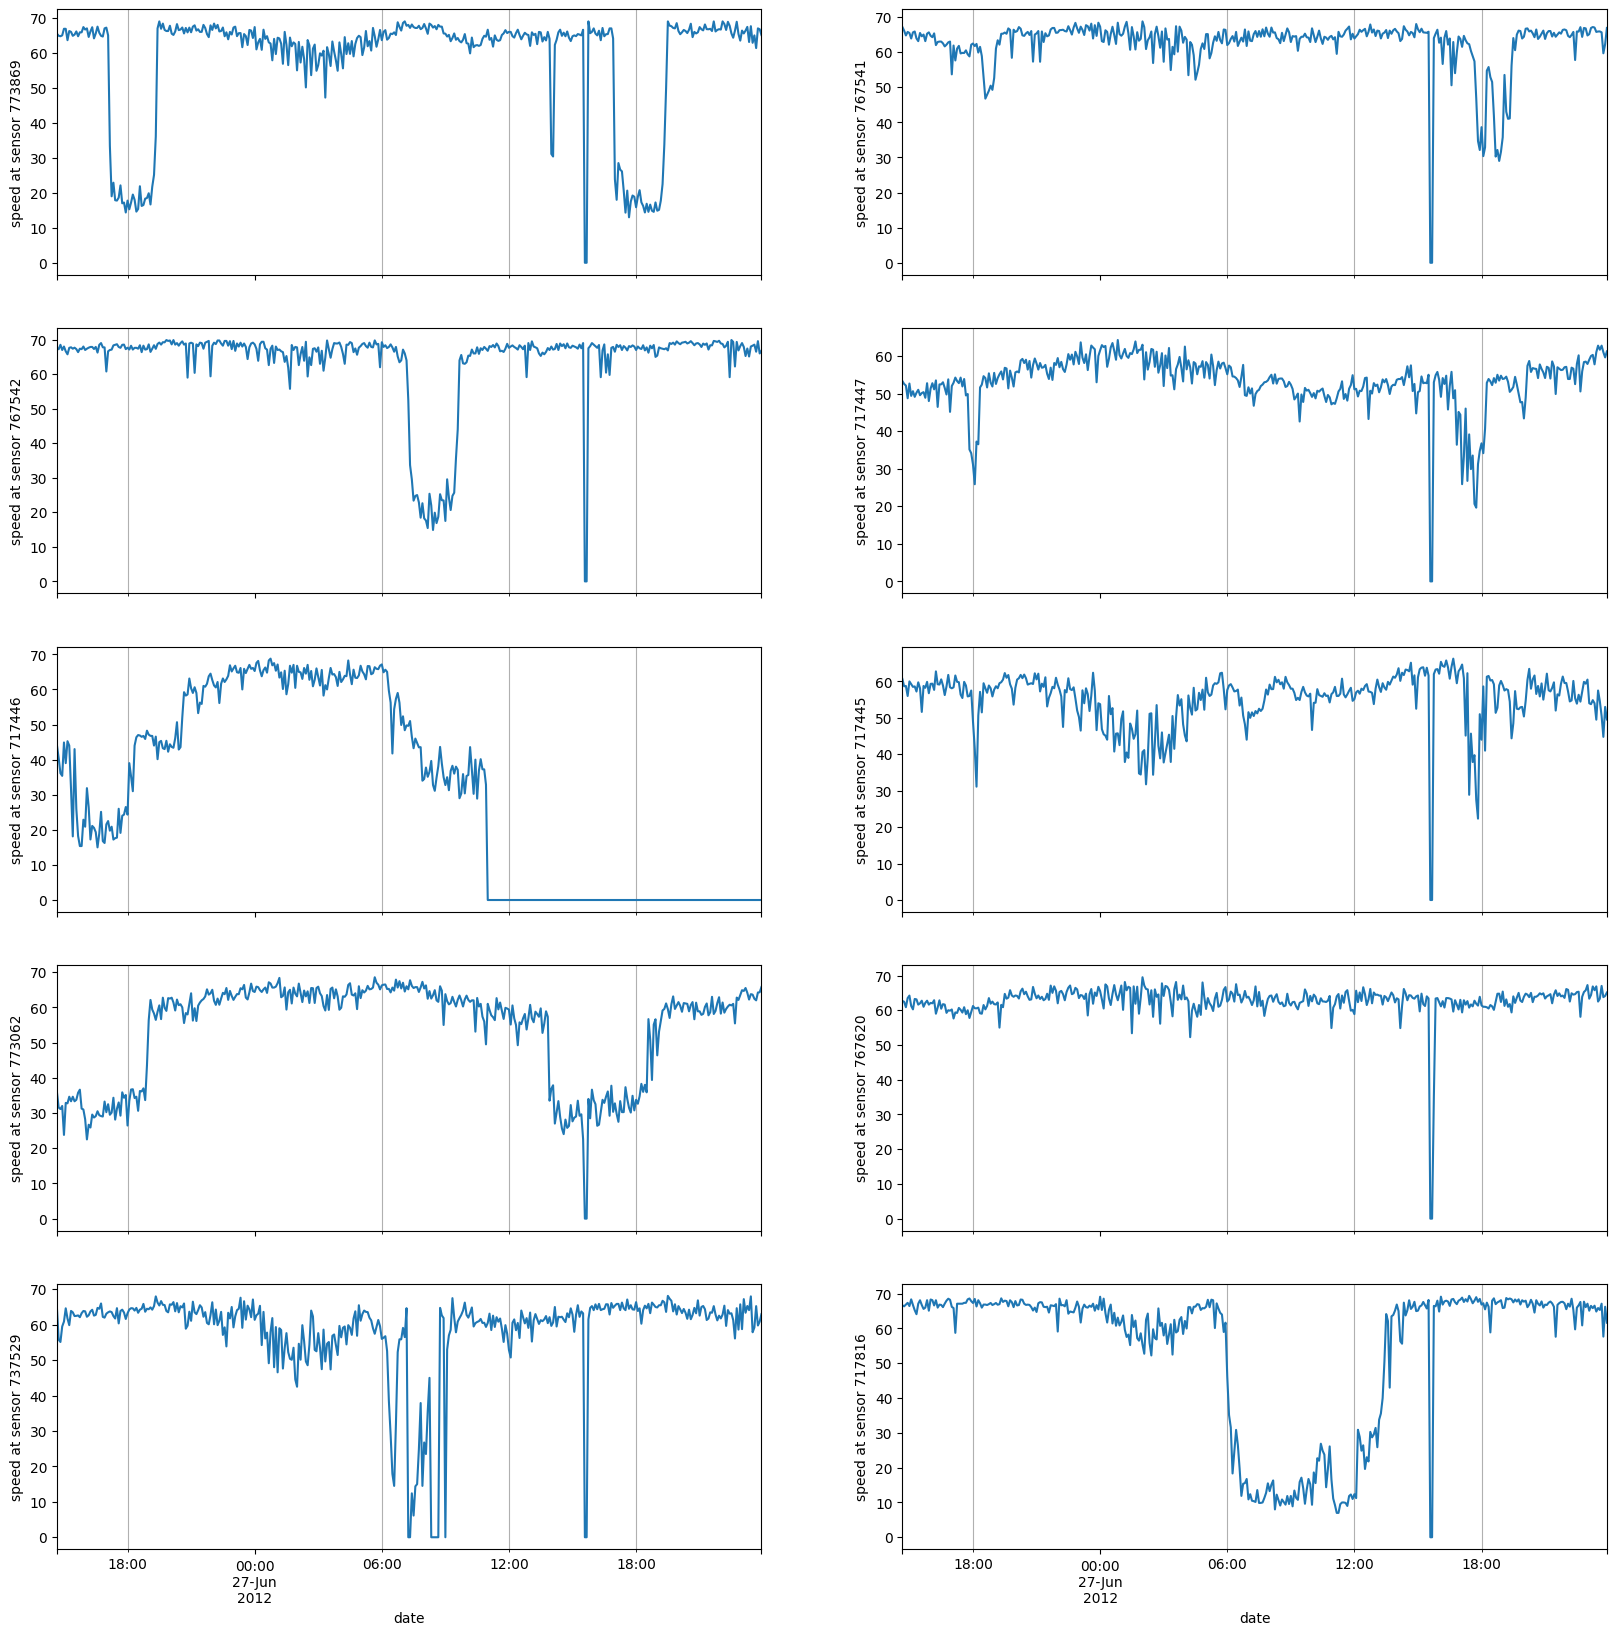

In [17]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    df[df.columns[i]].iloc[-400:,].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("speed at sensor " + str(df.columns[i]))   
    axx[i].grid(which='minor', axis='x')



In [22]:
agg_m["RMSE"], agg_m["MAPE"]

(2.9641129471655754, 0.03307056638538538)

gluonts.model.forecast.SampleForecast(info=None, item_id='0', samples=array([[65.70385 , 67.42533 , 64.46775 , ..., 66.73376 , 65.07833 ,
        66.73913 ],
       [66.33639 , 64.95453 , 65.26085 , ..., 65.393486, 65.91496 ,
        64.94037 ],
       [66.08217 , 65.15576 , 67.087265, ..., 63.594456, 66.2976  ,
        64.31862 ],
       ...,
       [65.21717 , 66.82329 , 65.29735 , ..., 67.975914, 64.41832 ,
        63.66091 ],
       [67.699005, 64.79888 , 65.67998 , ..., 66.51345 , 66.66234 ,
        62.84854 ],
       [66.42053 , 67.365295, 63.604748, ..., 66.6304  , 66.37615 ,
        67.039185]], dtype=float32), start_date=Period('2012-06-27 23:00', '5T'))
gluonts.model.forecast.SampleForecast(info=None, item_id='1', samples=array([[64.2497  , 66.87384 , 59.67118 , ..., 66.34409 , 66.89395 ,
        65.97907 ],
       [65.38787 , 65.726555, 63.1062  , ..., 65.3916  , 65.47704 ,
        69.28671 ],
       [61.53731 , 65.45744 , 64.81083 , ..., 65.82373 , 69.01043 ,
        67.375

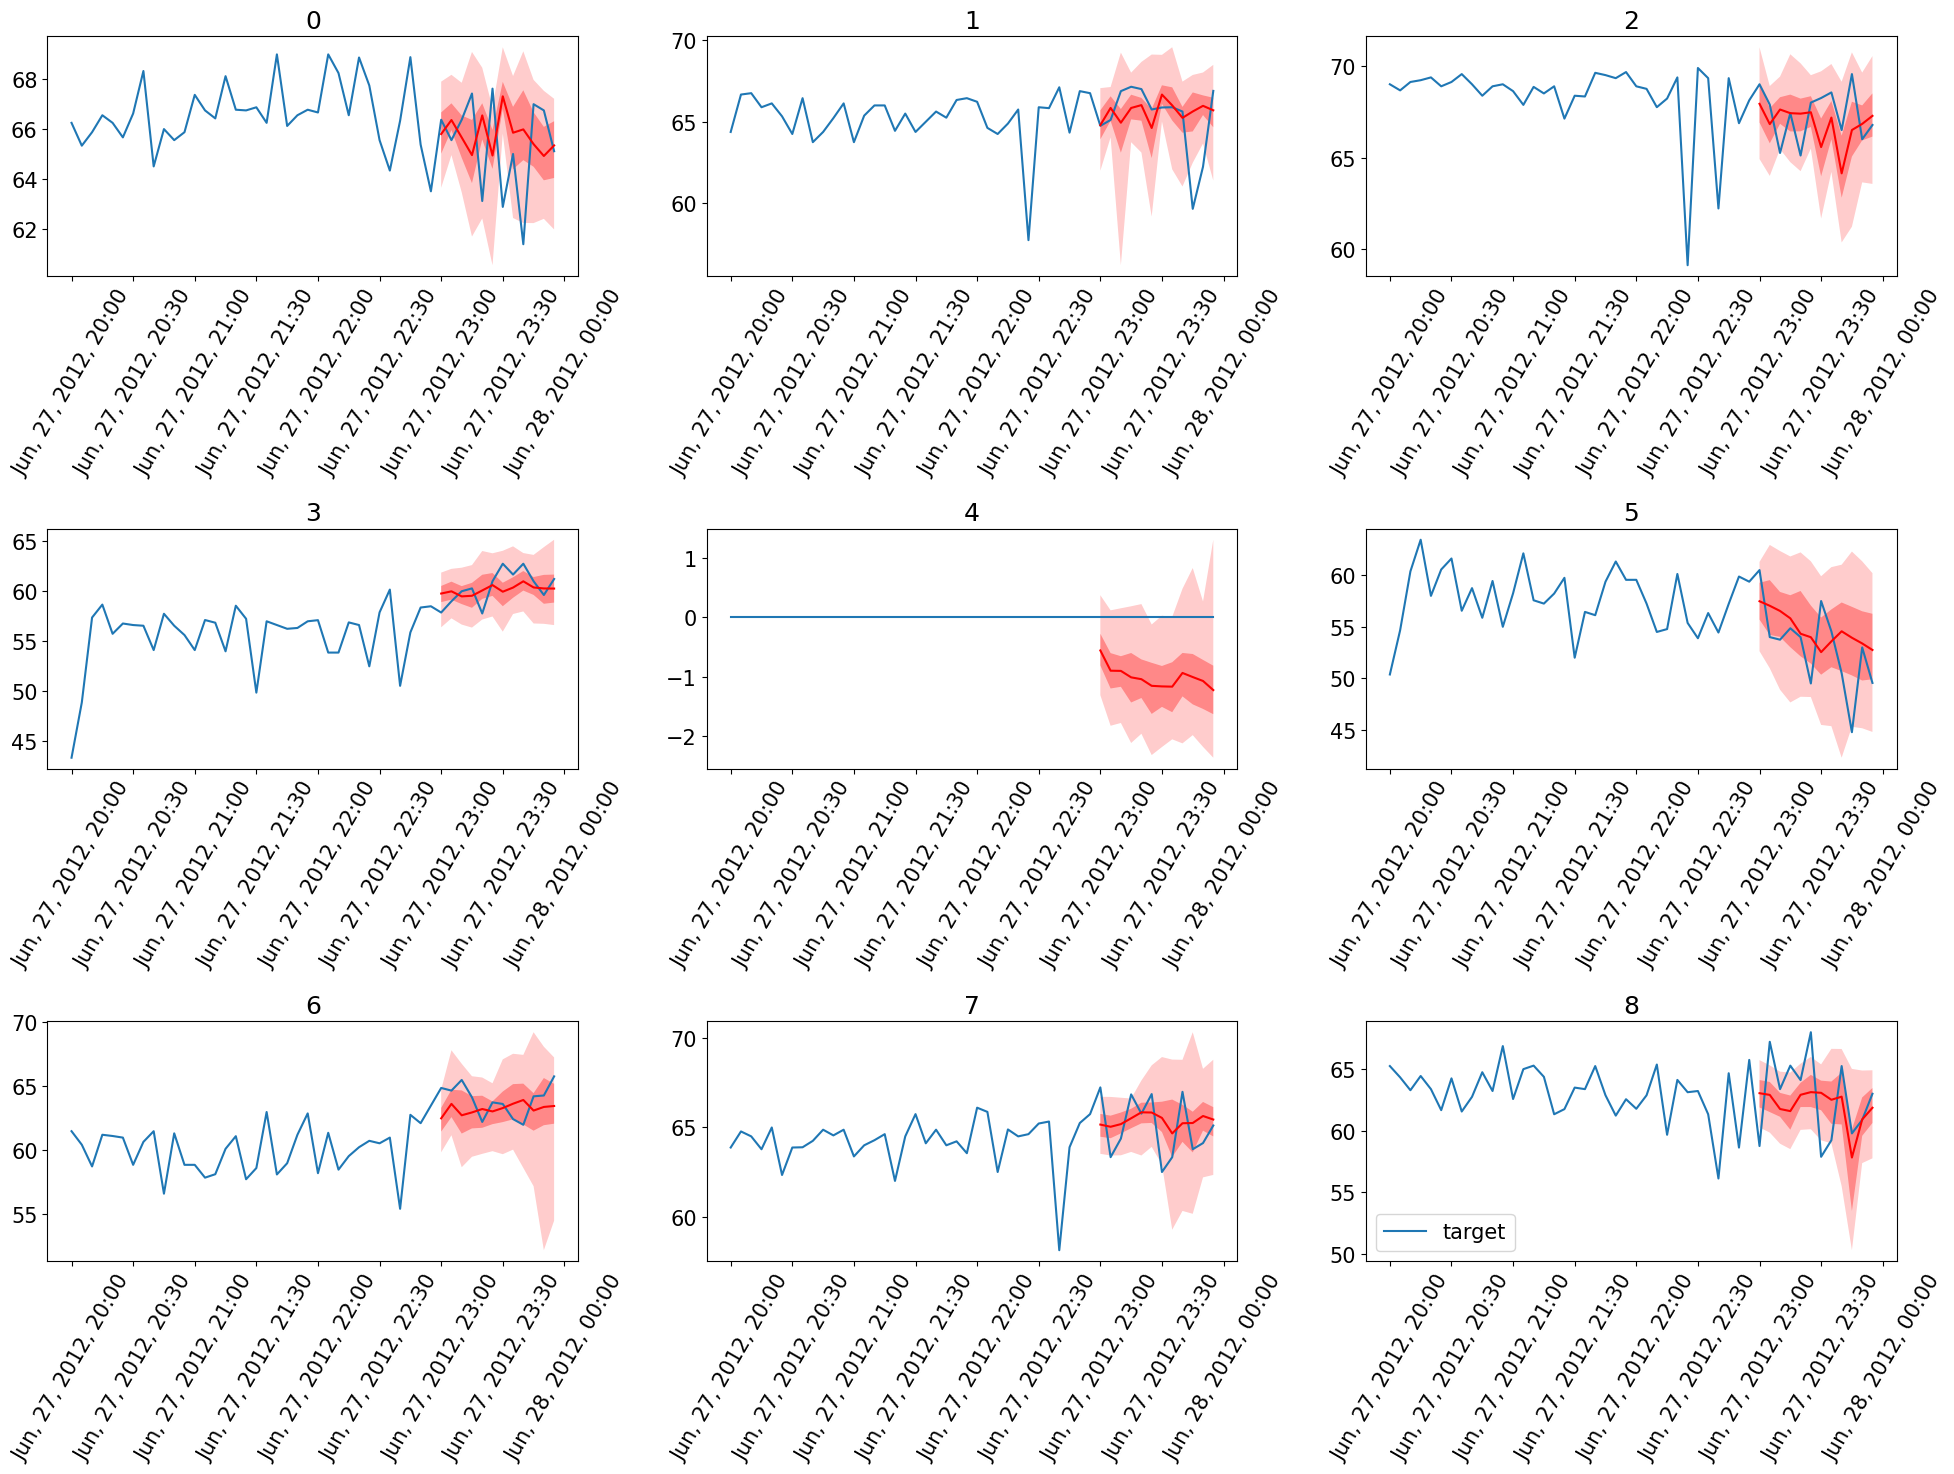

In [23]:
plot(forecast_it, ts_it)

In [107]:
dataset_ped = get_dataset("pedestrian_counts")

backtest_dataset = dataset_ped.test
prediction_length = dataset_ped.metadata.prediction_length
context_length = 32

gluonts.model.forecast.SampleForecast(info=None, item_id='0', samples=array([[64.80998 , 66.179695, 68.56447 , ..., 67.667915, 65.96904 ,
        66.6593  ],
       [64.86541 , 66.071785, 66.69852 , ..., 67.23988 , 65.78744 ,
        66.122795],
       [64.82893 , 66.057   , 66.93432 , ..., 67.29423 , 65.7445  ,
        65.9494  ],
       ...,
       [65.06494 , 65.82821 , 65.371765, ..., 67.1837  , 66.07085 ,
        65.99579 ],
       [64.877266, 65.85102 , 66.11839 , ..., 67.214966, 65.99604 ,
        65.919785],
       [65.27656 , 66.36071 , 65.86295 , ..., 67.18066 , 65.53    ,
        65.3169  ]], dtype=float32), start_date=Period('2012-06-27 23:00', '5T'))
gluonts.model.forecast.SampleForecast(info=None, item_id='1', samples=array([[67.68286 , 72.11767 , 65.882385, ..., 66.18654 , 67.46428 ,
        67.306496],
       [67.85423 , 66.58061 , 65.098946, ..., 65.84    , 66.991585,
        66.63189 ],
       [67.03602 , 65.47286 , 65.47529 , ..., 65.93576 , 66.81588 ,
        66.617

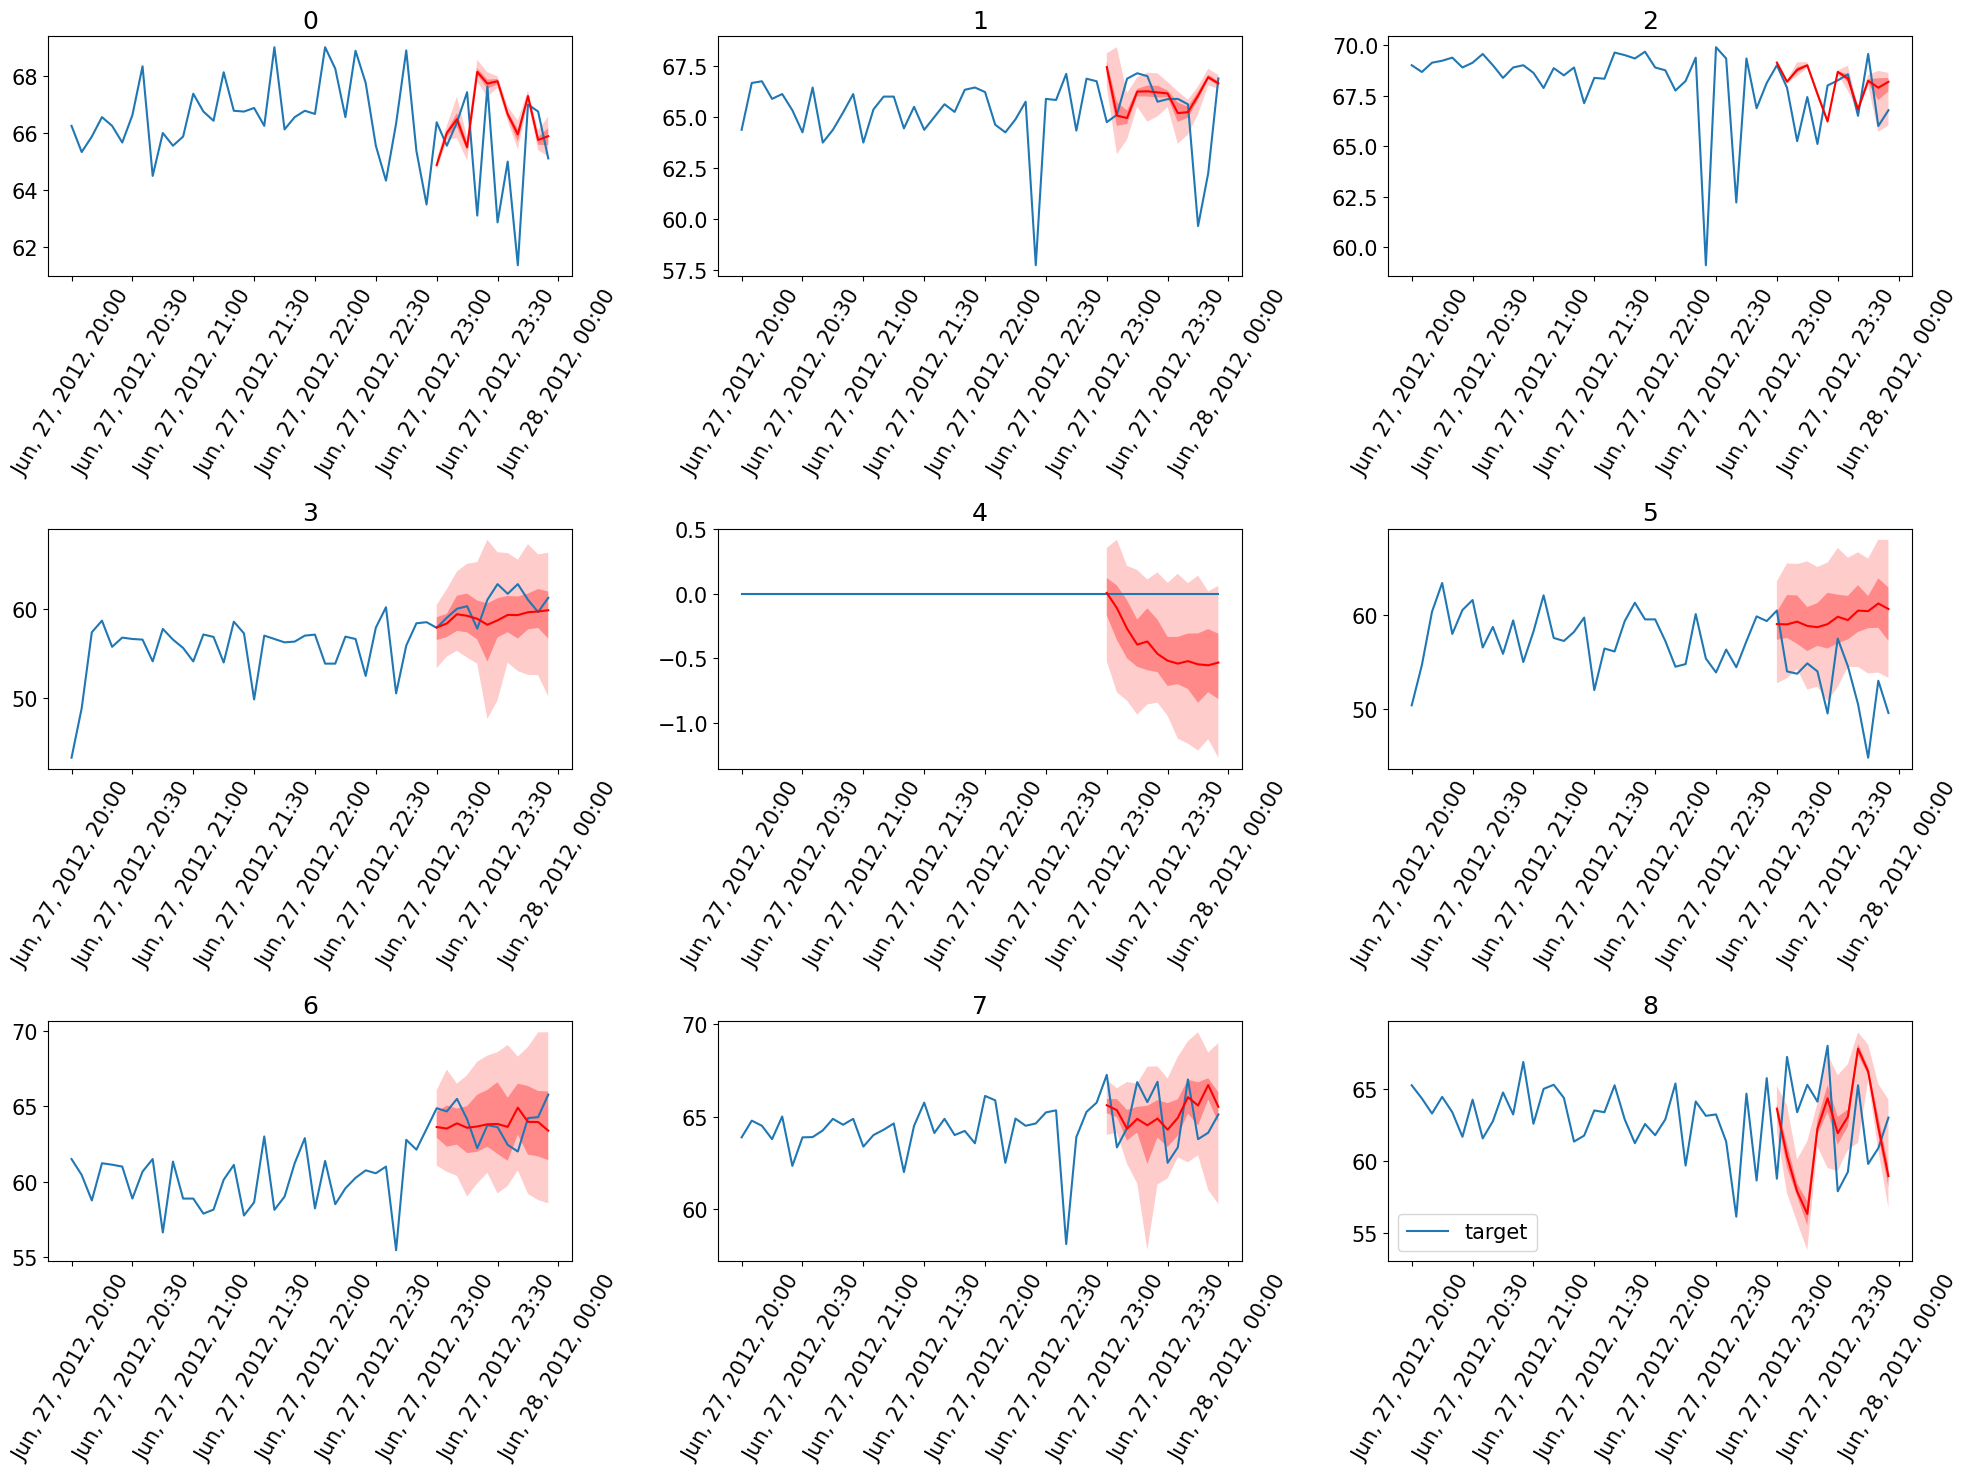

In [20]:
plot(forecast_it, ts_it)

In [5]:
lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_ped.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)
# evaluator = Evaluator(
#     # seasonality=1
# )
# agg_m, item_m = evaluator(
#     ts_iterator=ts_it,
#     fcst_iterator=forecast_it,
#     num_series=len(dataset.test),
# )
# print(json.dumps(agg_m, indent=4))
# forecast_it, ts_it = make_evaluation_predictions(
#     dataset=dataset.test,  # test dataset
#     predictor=predictor,  # predictor
#     num_samples=100,  # number of sample paths we want for evaluation
# )

window_length: 48


In [ ]:
# evaluator = Evaluator(
#     # seasonality=1
# )
# agg_m, item_m = evaluator(
#     ts_iterator=ts_it,
#     fcst_iterator=forecast_it,
#     num_series=len(dataset.test),
# )
# print(json.dumps(agg_m, indent=4))
# forecast_it, ts_it = make_evaluation_predictions(
#     dataset=dataset.test,  # test dataset
#     predictor=predictor,  # predictor
#     num_samples=100,  # number of sample paths we want for evaluation
# )

In [7]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [13]:
a = set()
for _ in range(len(dataset_ped.test)):
    a.add(next(iter(dataset_ped.test))["item_id"])
print(a)

{'T1'}


In [19]:
train_script(estimator,checkpoint=None)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Tota

None


KeyError: 'data_id'

/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/dataset/common.py:264: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)
/tmp/ipykernel_1086989/3362768894.py:11: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))


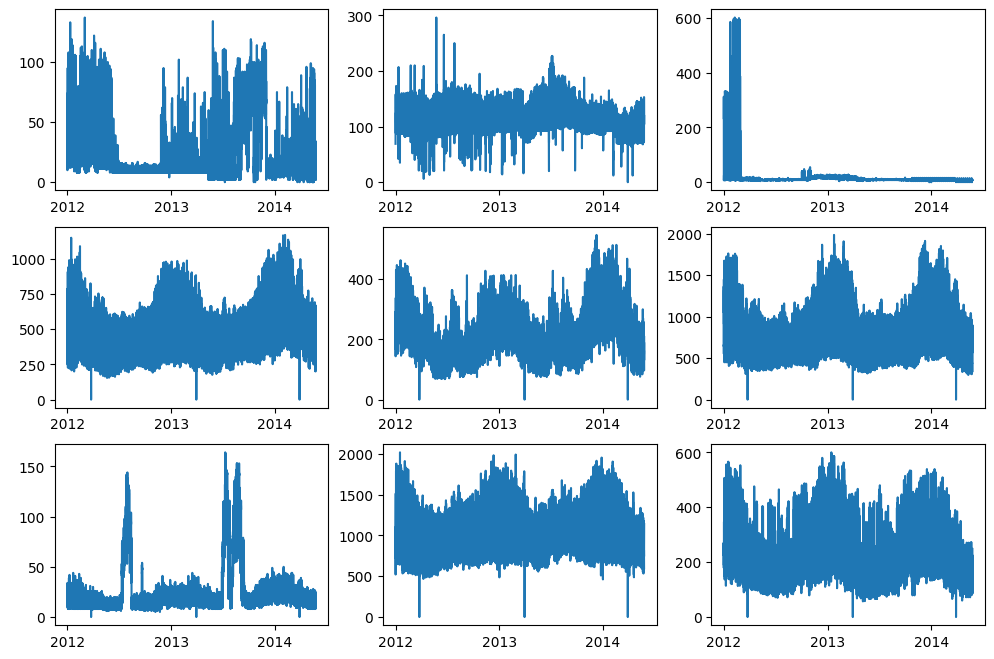

In [3]:
date_formater = mdates.DateFormatter("%Y")
fig = plt.figure(figsize=(12, 8))
for idx, entry in enumerate(islice(dataset.train, 9)):
    ax = plt.subplot(3, 3, idx + 1)
    t = pd.date_range(
        start=entry["start"].to_timestamp(),
        periods=len(entry["target"]),
        freq=entry["start"].freq,
    )
    plt.plot(t, entry["target"])
    plt.xticks(pd.date_range(start="2011-12-31", periods=3, freq="AS"))
    ax.xaxis.set_major_formatter(date_formater)

In [4]:

def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)

In [5]:
class FeedForwardNetwork(nn.Module):
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        hidden_dimensions: List[int],
        distr_output=StudentTOutput(),
        batch_norm: bool = False,
        scaling: Callable = mean_abs_scaling,
    ) -> None:
        super().__init__()

        assert prediction_length > 0
        assert context_length > 0
        assert len(hidden_dimensions) > 0

        self.prediction_length = prediction_length
        self.context_length = context_length
        self.hidden_dimensions = hidden_dimensions
        self.distr_output = distr_output
        self.batch_norm = batch_norm
        self.scaling = scaling

        dimensions = [context_length] + hidden_dimensions[:-1]

        modules = []
        for in_size, out_size in zip(dimensions[:-1], dimensions[1:]):
            modules += [self.__make_lin(in_size, out_size), nn.ReLU()]
            if batch_norm:
                modules.append(nn.BatchNorm1d(out_size))
        modules.append(
            self.__make_lin(dimensions[-1], prediction_length * hidden_dimensions[-1])
        )

        self.nn = nn.Sequential(*modules)
        self.args_proj = self.distr_output.get_args_proj(hidden_dimensions[-1])

    @staticmethod
    def __make_lin(dim_in, dim_out):
        lin = nn.Linear(dim_in, dim_out)
        torch.nn.init.uniform_(lin.weight, -0.07, 0.07)
        torch.nn.init.zeros_(lin.bias)
        return lin

    def forward(self, context):
        scale = self.scaling(context)
        scaled_context = context / scale
        nn_out = self.nn(scaled_context)
        nn_out_reshaped = nn_out.reshape(
            -1, self.prediction_length, self.hidden_dimensions[-1]
        )
        distr_args = self.args_proj(nn_out_reshaped)
        return distr_args, torch.zeros_like(scale), scale

    def get_predictor(self, input_transform, batch_size=32):
        return PyTorchPredictor(
            prediction_length=self.prediction_length,
            input_names=["past_target"],
            prediction_net=self,
            batch_size=batch_size,
            input_transform=input_transform,
            forecast_generator=DistributionForecastGenerator(self.distr_output),
        )

In [7]:
class LightningFeedForwardNetwork(FeedForwardNetwork, pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        context = batch["past_target"]
        target = batch["future_target"]

        assert context.shape[-1] == self.context_length
        assert target.shape[-1] == self.prediction_length

        distr_args, loc, scale = self(context)
        distr = self.distr_output.distribution(distr_args, loc, scale)
        loss = -distr.log_prob(target)

        return loss.mean()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [8]:
context_length = 2 * 7 * 24
prediction_length = dataset.metadata.prediction_length
hidden_dimensions = [96, 48]



In [9]:
net = LightningFeedForwardNetwork(
    prediction_length=prediction_length,
    context_length=context_length,
    hidden_dimensions=hidden_dimensions,
    distr_output=StudentTOutput(),
)


In [10]:
sum(np.prod(p.shape) for p in net.parameters())

144243

In [11]:
for p in net.parameters():
    print(p.shape)



torch.Size([96, 336])
torch.Size([96])
torch.Size([1152, 96])
torch.Size([1152])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])


In [13]:
mask_unobserved = AddObservedValuesIndicator(
    target_field=FieldName.TARGET,
    output_field=FieldName.OBSERVED_VALUES,
)

In [14]:
training_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,
        min_future=prediction_length,
    ),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [16]:
batch_size = 32
num_batches_per_epoch = 50

In [17]:
data_loader = TrainDataLoader(
    # We cache the dataset, to make training faster
    Cached(dataset.train),
    batch_size=batch_size,
    stack_fn=batchify,
    transform=mask_unobserved + training_splitter,
    num_batches_per_epoch=num_batches_per_epoch,
)

In [18]:
trainer = pl.Trainer(max_epochs=10, devices=2)
trainer.fit(net, data_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for perfor

Epoch 9: |          | 50/? [00:00<00:00, 162.19it/s, v_num=2]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: |          | 50/? [00:00<00:00, 158.87it/s, v_num=2]


In [19]:
prediction_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=TestSplitSampler(),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [20]:
predictor_pytorch = net.get_predictor(mask_unobserved + prediction_splitter)

In [22]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, predictor=predictor_pytorch
)

forecasts_pytorch = list(f.to_sample_forecast() for f in forecast_it)
tss_pytorch = list(ts_it)



In [30]:
forecasts_pytorch

[gluonts.model.forecast.SampleForecast(info=None, item_id='0', samples=array([[13.495745 , 25.984465 , 28.444345 , ..., 19.165245 , 21.197712 ,
         20.712902 ],
        [13.039831 , 30.065247 , 27.23784  , ..., 16.559652 , 25.070011 ,
         16.732994 ],
        [12.0920725, 32.074047 , 26.951431 , ..., 20.291986 , 20.601223 ,
         20.259007 ],
        ...,
        [ 6.3144693, 26.203775 , 22.896877 , ..., 23.29262  , 27.206955 ,
         21.680628 ],
        [ 9.072409 , 22.59972  , 27.938644 , ..., 20.447441 , 24.584316 ,
         18.564838 ],
        [11.899094 , 20.726503 , 33.44385  , ..., 22.257315 , 21.162424 ,
         18.386723 ]], dtype=float32), start_date=Period('2014-05-26 20:00', 'h')),
 gluonts.model.forecast.SampleForecast(info=None, item_id='1', samples=array([[120.76962 ,  99.74353 , 101.121254, ...,  94.576195, 106.04621 ,
         113.29786 ],
        [133.02356 , 104.413795, 123.007515, ...,  99.34862 , 118.23983 ,
         125.033676],
        [109.2990

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

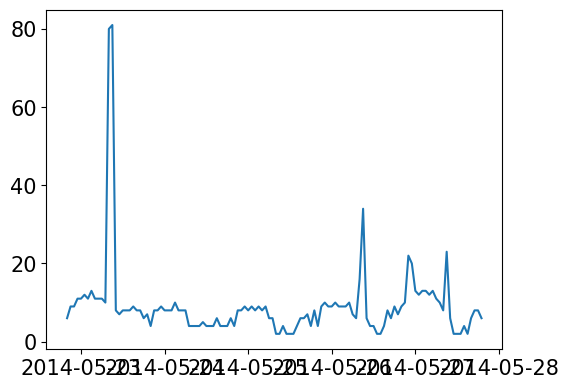

In [31]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-5 * prediction_length :].to_timestamp(), label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()


In [32]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])



metrics_pytorch, _ = evaluator(tss_pytorch, forecasts_pytorch)
pd.DataFrame.from_records(metrics_pytorch, index=["FeedForward"]).transpose()


Running evaluation: 2247it [00:00, 39991.69it/s]
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/seyed/miniconda3/envs/env/lib/python3.11/site-packages/gluonts/evaluation/_base.py:422: R

,FeedForward
Coverage[0.1],7.584186e-02
Coverage[0.5],4.775627e-01
Coverage[0.9],9.098428e-01
MAE_Coverage,4.098428e-01
MAPE,1.524454e-01
MASE,9.879244e-01
MSE,3.879518e+06
MSIS,9.120898e+00
ND,9.521912e-02
NRMSE,8.257545e-01
